<a href="https://colab.research.google.com/github/jmrojo98/flying-dog-beers/blob/master/Proyecto_transito_v3_mapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalo Geopandas
!pip install geopandas
# Instalación dash
!pip install jupyter-dash
!pip install dash 
!pip install dash_core_components
!pip install dash_html_components
!pip install dash_table
!pip install plotly

     |████████████████████████████████| 972kB 5.7MB/s 
     |████████████████████████████████| 14.8MB 289kB/s 
     |████████████████████████████████| 6.5MB 35.3MB/s 


In [14]:
import pandas as pd
import numpy as np
# Sirve para ver si una coordenada esta dentro de un poligono
from matplotlib import path
import matplotlib.pyplot as plt
# Sirve para generar mapas a partir de coordenadas
import geopandas as gpd
# Transforma columna str en geometry
from shapely import wkt
import folium 
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap


# import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output,State
import dash_table

import plotly.express as px

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importo dataset de barrios 
# En la columna WKT figuran todas las coordenadas limites de cada barrio
barrios = pd.read_csv('/content/drive/MyDrive/PROYECTO/barrios.csv')
barrios.head()

FileNotFoundError: ignored

# Sección nueva

# Sección nueva

In [ ]:
# Transformo esa cadena de texto en un array con todos los puntos limites del barrio
def definir_coordenadas(poligono):
  linea = poligono[10:len(poligono)-2].split(',')
  # Me quedo solo con los numeros y formo una lista
  # POLYGON ((-58.4528200492791 -34.5959886570639 ... ))
  # [-58.4528200492791 -34.5959886570639 , ... ]
  coor = []
  # Recorro la lista
  for i in linea:
    # Cada punto lo divido por longitus y latitud
    temp = i.split(' ')
    # Agrego a una lista una tupla (long,lat)
    # remplazo algun ( o ) colgado por '' y los transformo en float
    coor.append( ( float(temp[0].replace('(','').replace(')','')) , float(temp[1].replace('(','').replace(')','')) ) )
  return coor

In [ ]:
# Hago una lista de listas con todos los limites de los barrios
limites = [definir_coordenadas(i) for i in barrios.WKT]

In [ ]:
# Lo sumo al dataframe
barrios['limites'] = limites

In [ ]:
# Creo otro dataframe solo con los datos que me interesan
df_barrios = barrios.loc[:,['WKT','barrio','limites']]
df_barrios.head()

,WKT,barrio,limites
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,"[(-58.4528200492791, -34.5959886570639), (-58...."
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,"[(-58.4655768128541, -34.5965577078058), (-58...."
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,"[(-58.4237529813037, -34.5978273383243), (-58...."
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,"[(-58.4946097568899, -34.6148652395239), (-58...."
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,"[(-58.4128700313089, -34.6141162515854), (-58...."


In [ ]:
# Creo una funcion que toma una latitud, una longitud y devuelve en que barrio esta
def punto_limite(lat,long,barrios):
  for i in range(len(barrios.limites)):
    # Uso una funcion de matplotlib.path que devuelve True o False si un punto esta en un poligono 
    p = path.Path(barrios.limites[i])
    if p.contains_points([(long,lat)]):
      # Si encuentra el barrio lo devuelve
      return barrios.barrio[i]
  # Si no pertenece a capital devuelve NaN de numpy
  return np.NaN

In [ ]:
# Una funcion que dado un dataframe crea una lista de los barrios que pertenecen las coordenadas
def clasificar_barrio(df,barrios):
  barrios_lista = []
  for i in range(df.shape[0]):
    barrios_lista.append(punto_limite(df['lat'][i],df['long'][i],barrios))
  return barrios_lista

In [ ]:
# Levanto dataset de colectivos (Muchas paradas pertenecen a provincia)
colectivo = pd.read_csv('/content/drive/MyDrive/PROYECTO/paradas-de-colectivo.csv')

In [ ]:
# Cambio los nombres de las columnas
colectivo.rename(columns={'stop_lat':'lat','stop_lon':'long'},inplace=True)

In [ ]:
# Agrego el barrio o NaN a cada parada
colectivo['barrio'] = clasificar_barrio(colectivo,df_barrios)
colectivo.head()

,stop_id,stop_code,stop_name,lat,long,direction_id,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,barrio
0,201,201,1520 DEFENSA,-34.625663,-58.371042,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,SAN TELMO
1,2072,2072,722 REGIMIENTO DE PATRICIOS AV.,-34.636743,-58.369765,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
2,2079,2079,324 REGIMIENTO DE PATRICIOS AV.,-34.632942,-58.370332,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
3,2084,2084,16 REGIMIENTO DE PATRICIOS AV.,-34.629952,-58.370600,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
4,20350,20350,1776 MONTES DE OCA MANUEL AV.,-34.647807,-58.372853,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BARRACAS


In [ ]:
# Me quedo solo con las paradas que pertenecen a capital
colectivos_capital = colectivo.loc[~colectivo.barrio.isna(),:]

In [ ]:
colectivos_capital.reset_index(inplace=True)

In [ ]:
colectivos_capital.head(20)

,index,stop_id,stop_code,stop_name,lat,long,direction_id,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,barrio
0,0,201,201,1520 DEFENSA,-34.625663,-58.371042,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,SAN TELMO
1,1,2072,2072,722 REGIMIENTO DE PATRICIOS AV.,-34.636743,-58.369765,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
2,2,2079,2079,324 REGIMIENTO DE PATRICIOS AV.,-34.632942,-58.370332,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
3,3,2084,2084,16 REGIMIENTO DE PATRICIOS AV.,-34.629952,-58.370600,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BOCA
4,4,20350,20350,1776 MONTES DE OCA MANUEL AV.,-34.647807,-58.372853,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BARRACAS
5,5,20358,20358,1358 MONTES DE OCA MANUEL AV.,-34.643285,-58.373720,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,BARRACAS
6,6,20590,20590,368 YRIGOYEN HIPOLITO AV.,-34.608873,-58.371667,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,MONSERRAT
7,7,204216,204216,1291 GILARDI GILARDO,-34.591115,-58.373402,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,RETIRO
8,8,204249,204249,1557 RAMOS MEJIA JOSE MARIA DR. AV.,-34.589582,-58.372450,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,RETIRO
9,9,204264,204264,2033 PY COMODORO AV.,-34.588083,-58.368398,1,108,26,22A,JNAMBA022,Retiro - Cno. Centenario y Lavalleja,3,RETIRO


In [ ]:
# Cuantas paradas de colectivos tiene cada barrio
colectivos_capital.barrio.value_counts()

PALERMO              525
BALVANERA            392
CABALLITO            367
FLORES               344
VILLA LUGANO         317
RECOLETA             311
BARRACAS             284
ALMAGRO              265
BELGRANO             248
RETIRO               242
MATADEROS            241
CONSTITUCION         239
SAAVEDRA             231
VILLA DEVOTO         229
NUEVA POMPEYA        228
VILLA URQUIZA        215
VILLA CRESPO         209
LINIERS              203
SAN NICOLAS          194
PARQUE AVELLANEDA    187
PARQUE PATRICIOS     185
MONSERRAT            184
CHACARITA            183
BOCA                 167
BOEDO                161
SAN CRISTOBAL        144
VILLA PUEYRREDON     144
PARQUE CHACABUCO     140
VELEZ SARSFIELD      121
FLORESTA             118
VILLA DEL PARQUE     109
SAN TELMO            100
COLEGIALES            99
VILLA RIACHUELO       97
VILLA LURO            95
NUÑEZ                 92
VILLA REAL            83
VILLA ORTUZAR         81
VILLA GRAL. MITRE     75
MONTE CASTRO          75


In [ ]:
# Armo un dataset con esos valores
colectivos_ = pd.DataFrame(colectivos_capital.barrio.value_counts().reset_index()).rename(columns={'index':'barrio','barrio':'colectivos'})
colectivos_.head()

,barrio,colectivos
0,PALERMO,525
1,BALVANERA,392
2,CABALLITO,367
3,FLORES,344
4,VILLA LUGANO,317


In [ ]:
# Levanto el dataset de subtes
subte = pd.read_csv('/content/drive/MyDrive/PROYECTO/estaciones-de-subte.csv')
subte.head()

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H


In [ ]:
# Clasifico las paradas segun el barrio
subte['barrio'] = clasificar_barrio(subte,df_barrios)
subte.head()

,long,lat,id,estacion,linea,barrio
0,-58.398928,-34.635750,1.0,CASEROS,H,PARQUE PATRICIOS
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,PARQUE PATRICIOS
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,SAN CRISTOBAL
3,-58.404732,-34.615242,4.0,VENEZUELA,H,BALVANERA
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,BALVANERA


In [ ]:
# Levanto Dataset del premetro
premetro = pd.read_csv('/content/drive/MyDrive/PROYECTO/estaciones-premetro.csv')
premetro.head()

,long,lat,id,linea,nombre
0,-58.461491,-34.643757,1,PREMETRO,INTENDENTE SAGUIER
1,-58.456415,-34.648601,2,PREMETRO,BALBASTRO (Cementerio de Flores)
2,-58.450047,-34.659499,3,PREMETRO,ANA MARÍA JANER
3,-58.446607,-34.662225,4,PREMETRO,FERNANDEZ DE LA CRUZ
4,-58.448513,-34.665368,5,PREMETRO,PTE. ILLIA (Lacarra)


In [ ]:
# Cambio el nombre de la columna para que me quede igual que el subte
premetro.rename(columns={'nombre':'estacion'},inplace=True)

In [ ]:
# Clasifico los barrios
premetro['barrio'] = clasificar_barrio(premetro,df_barrios)
premetro.head()

,long,lat,id,linea,estacion,barrio
0,-58.461491,-34.643757,1,PREMETRO,INTENDENTE SAGUIER,FLORES
1,-58.456415,-34.648601,2,PREMETRO,BALBASTRO (Cementerio de Flores),FLORES
2,-58.450047,-34.659499,3,PREMETRO,ANA MARÍA JANER,VILLA SOLDATI
3,-58.446607,-34.662225,4,PREMETRO,FERNANDEZ DE LA CRUZ,VILLA SOLDATI
4,-58.448513,-34.665368,5,PREMETRO,PTE. ILLIA (Lacarra),VILLA SOLDATI


In [ ]:
# Concateno los dos DataFrames
subte_premetro = pd.concat([subte,premetro],axis=0)
subte_premetro

,long,lat,id,estacion,linea,barrio
0,-58.398928,-34.635750,1.0,CASEROS,H,PARQUE PATRICIOS
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,PARQUE PATRICIOS
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,SAN CRISTOBAL
3,-58.404732,-34.615242,4.0,VENEZUELA,H,BALVANERA
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,BALVANERA
...,...,...,...,...,...,...
13,-58.466923,-34.680883,14.0,ANA DÍAZ,PREMETRO,VILLA LUGANO
14,-58.456480,-34.654433,15.0,MARIANO ACOSTA (Bo. R. Carrillo),PREMETRO,VILLA SOLDATI
15,-58.453905,-34.656441,16.0,SOMELLERA,PREMETRO,VILLA SOLDATI
16,-58.448861,-34.660458,17.0,NTRA. SRA. DE FÁTIMA,PREMETRO,VILLA SOLDATI


In [ ]:
# Me fijo cuantas paradas hay por barrio
subte_premetro.barrio.value_counts()

BALVANERA           13
SAN NICOLAS         10
MONSERRAT            9
VILLA SOLDATI        8
VILLA LUGANO         7
FLORES               7
PALERMO              6
RECOLETA             6
CONSTITUCION         5
ALMAGRO              5
SAN CRISTOBAL        5
CABALLITO            4
PARQUE PATRICIOS     4
RETIRO               4
PARQUE CHACABUCO     3
VILLA ORTUZAR        2
BELGRANO             2
CHACARITA            2
VILLA URQUIZA        2
VILLA RIACHUELO      1
VILLA CRESPO         1
BOEDO                1
COLEGIALES           1
Name: barrio, dtype: int64

In [ ]:
# Armo un dataset con esos valores
subte_premetro_ = pd.DataFrame(subte_premetro.barrio.value_counts().reset_index()).rename(columns={'index':'barrio','barrio':'subte'})
subte_premetro_.head()

,barrio,subte
0,BALVANERA,13
1,SAN NICOLAS,10
2,MONSERRAT,9
3,VILLA SOLDATI,8
4,VILLA LUGANO,7


In [ ]:
# Levanto el dataset de trenes
trenes = pd.read_csv('/content/drive/MyDrive/PROYECTO/estaciones_trenes.csv',sep=';')
trenes.rename(columns={'latitud':'lat','longitud':'long'},inplace=True)

In [ ]:
trenes['barrio'] = clasificar_barrio(trenes,df_barrios)
trenes

,mes,linea,ramal,estacion,lat,long,barrio
0,12/2018,Urquiza,Lemos,Tropezón,-34.591953,-58.559179,NaN
1,12/2018,Urquiza,Lemos,Teniente Agneta,-34.548800,-58.678850,NaN
2,12/2018,Urquiza,Lemos,Sargento Cabral,-34.537187,-58.694932,NaN
3,12/2018,Urquiza,Lemos,Sargento Barrufaldi,-34.562450,-58.660275,NaN
4,12/2018,Urquiza,Lemos,Rubén Darío,-34.587484,-58.631454,NaN
...,...,...,...,...,...,...,...
3017,06/2017,Belgrano Norte,Villa Rosa,Don Torcuato,-34.502657,-58.642002,NaN
3018,06/2017,Belgrano Norte,Villa Rosa,Del Viso,-34.453694,-58.796119,NaN
3019,06/2017,Belgrano Norte,Villa Rosa,Carapachay,-34.528805,-58.537264,NaN
3020,06/2017,Belgrano Norte,Villa Rosa,Boulogne Sur,-34.508711,-58.565298,NaN


In [ ]:
# Me quedo con las estaciones que estan en capital
trenes_capital = trenes.loc[~trenes.barrio.isna(),:]
# Elimino las estaciones repetidas, ya que hay varias que figuran varias veces por pertenecer a ramales diferentes
trenes_capital = trenes_capital.drop_duplicates(['estacion'], keep='first')
trenes_capital.reset_index(inplace=True)
trenes_capital.head()

,index,mes,linea,ramal,estacion,lat,long,barrio
0,5,12/2018,Urquiza,Lemos,Pedro Arata,-34.592420,-58.474807,PATERNAL
1,11,12/2018,Urquiza,Lemos,José Artigas,-34.590031,-58.466273,VILLA ORTUZAR
2,15,12/2018,Urquiza,Lemos,Federico Lacroze,-34.586715,-58.455586,CHACARITA
3,16,12/2018,Urquiza,Lemos,El Libertador,-34.594331,-58.502336,AGRONOMIA
4,18,12/2018,Urquiza,Lemos,Dr. Francisco Beiró,-34.593146,-58.494176,AGRONOMIA


In [ ]:
# Armo un dataset con esos valores
trenes_capital_ = pd.DataFrame(trenes_capital.barrio.value_counts().reset_index()).rename(columns={'index':'barrio','barrio':'trenes'})
trenes_capital_

,barrio,trenes
0,BELGRANO,8
1,PALERMO,5
2,VILLA URQUIZA,4
3,VILLA SOLDATI,4
4,NUÑEZ,4
5,VILLA DEVOTO,3
6,NUEVA POMPEYA,3
7,BARRACAS,3
8,CONSTITUCION,3
9,COGHLAN,2


In [ ]:
# Levanto dataset de bicis
bicis = pd.read_csv('/content/drive/MyDrive/PROYECTO/estaciones-bicicletas-publicas.csv')
bicis

,WKT,id,numero,nombre,ubicacion,tipo,horario,anclajes_t
0,POINT (-58.3747109506359 -34.5924239181221),2,2,002 - Retiro I,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
1,POINT (-58.368256111128 -34.611033074021),3,3,003 - ADUANA,Moreno & Av Paseo Colon,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
2,POINT (-58.3687766674259 -34.6018228613782),4,4,004 - Plaza Roma,Lavalle & Bouchard,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
3,POINT (-58.420951914897 -34.5805498216604),5,5,005 - Plaza Italia,Av. Sarmiento 2601,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,42
4,POINT (-58.3697538990917 -34.6285274659984),6,6,006 - Parque Lezama,"Avenida Martin Garcia, 295",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
...,...,...,...,...,...,...,...,...
195,POINT (-58.4594980806633 -34.5445021121101),396,435,227 -Club Ciudad de Buenos Aires,Miguel Sanchez y Av Libertadores,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,16
196,POINT (-58.3747959781335 -34.6098020140517),398,441,016 - Legislatura,"169 Peru & Roca, Julio A., Presidente Diagonal...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20
197,POINT (-58.370711799739 -34.6089370142298),401,444,061-Ministerio de Economia,"Balcarce & Yrigoyen, Hipolito Av.",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,24
198,POINT (-58.3788579541696 -34.5824223699167),403,448,393 - Barrio 31,Carlos H. Perette 11,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,24


In [ ]:
# Creo funcion para convertir la columna WKT en dos columnas lat y long como los demas dataset
def coordenadas(points):
  lats = []
  longs = []
  for point in points:
    # Transformo esto POINT (-58.370711799739 -34.6089370142298) en esto -58.370711799739 -34.6089370142298
    temp = point[7:-1].split(' ')
    # Agrego las longitudes a una lista
    longs.append(float(temp[0]))
    # Agrego las latitudes a una lista
    lats.append(float(temp[1]))
  return lats,longs

In [ ]:
lats,longs = coordenadas(bicis.WKT)

In [ ]:
# Las agrego al DataFrame
bicis['lat'] = lats
bicis['long'] = longs

In [ ]:
# Clasifico las estaciones por barrio
bicis['barrio'] = clasificar_barrio(bicis,df_barrios)
bicis.head()

,WKT,id,numero,nombre,ubicacion,tipo,horario,anclajes_t,lat,long,barrio
0,POINT (-58.3747109506359 -34.5924239181221),2,2,002 - Retiro I,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.592424,-58.374711,RETIRO
1,POINT (-58.368256111128 -34.611033074021),3,3,003 - ADUANA,Moreno & Av Paseo Colon,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.611033,-58.368256,MONSERRAT
2,POINT (-58.3687766674259 -34.6018228613782),4,4,004 - Plaza Roma,Lavalle & Bouchard,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.601823,-58.368777,SAN NICOLAS
3,POINT (-58.420951914897 -34.5805498216604),5,5,005 - Plaza Italia,Av. Sarmiento 2601,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,42,-34.580550,-58.420952,PALERMO
4,POINT (-58.3697538990917 -34.6285274659984),6,6,006 - Parque Lezama,"Avenida Martin Garcia, 295",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.628527,-58.369754,SAN TELMO


In [ ]:
# Cuento cuantas estaciones hay por barrio
bicis.barrio.value_counts()

PALERMO              29
RECOLETA             19
SAN NICOLAS          16
BALVANERA            13
CABALLITO            11
MONSERRAT            10
BELGRANO             10
VILLA CRESPO          9
ALMAGRO               9
RETIRO                8
BOCA                  7
PARQUE PATRICIOS      6
SAN TELMO             5
BARRACAS              4
CONSTITUCION          4
CHACARITA             4
FLORES                4
COLEGIALES            3
PUERTO MADERO         3
PARQUE CHACABUCO      3
SAN CRISTOBAL         3
VILLA URQUIZA         3
SAAVEDRA              2
BOEDO                 2
NUÑEZ                 2
VILLA GRAL. MITRE     2
NUEVA POMPEYA         2
PATERNAL              1
COGHLAN               1
FLORESTA              1
VILLA ORTUZAR         1
Name: barrio, dtype: int64

In [ ]:
# Armo un dataset con esos valores
bicis_ = pd.DataFrame(bicis.barrio.value_counts().reset_index()).rename(columns={'index':'barrio','barrio':'bicis'})
bicis_

,barrio,bicis
0,PALERMO,29
1,RECOLETA,19
2,SAN NICOLAS,16
3,BALVANERA,13
4,CABALLITO,11
5,MONSERRAT,10
6,BELGRANO,10
7,VILLA CRESPO,9
8,ALMAGRO,9
9,RETIRO,8


In [ ]:
# Del DataFrame de barrio solo me quedo con las dos columnas
barrios_ = df_barrios.loc[:,['WKT','barrio']]
barrios_

,WKT,barrio
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO
6,"POLYGON ((-58.4819203599833 -34.6242871724757,...",VILLA SANTA RITA
7,"POLYGON ((-58.5034920611534 -34.6240324216321,...",MONTE CASTRO
8,"POLYGON ((-58.525116079791 -34.613999981063,-5...",VILLA REAL
9,"POLYGON ((-58.4604133778842 -34.6567978457031,...",FLORES


In [ ]:
# Concateno todos los DataFrame
barrios_estaciones = barrios_.merge(colectivos_,how='left')
barrios_estaciones = barrios_estaciones.merge(subte_premetro_,how='left')
barrios_estaciones = barrios_estaciones.merge(trenes_capital_,how='left')
barrios_estaciones = barrios_estaciones.merge(bicis_,how='left')
barrios_estaciones.head()

,WKT,barrio,colectivos,subte,trenes,bicis
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,183,2.0,1.0,4.0
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,60,NaN,2.0,1.0
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,209,1.0,1.0,9.0
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,109,NaN,2.0,NaN
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,265,5.0,NaN,9.0


In [ ]:
# Relleno los datos NaN por 0
barrios_estaciones = barrios_estaciones.fillna(0)

In [ ]:
# Guardo el dataframe en un archivo para levantarlo con mayor facilidad si lo quiero volver a usar
barrios_estaciones.to_csv('/content/drive/MyDrive/Colab Notebooks/DATOS EANT/PROYECTO/barrios2.csv')

In [ ]:
# Genero un puntaje de acceso teniendo en cuenta.
# Estaciones de trenes: 20pts
# Estaciones de subte: 10pts
# Estaciones de colectivos: 3pts
# Estaciones de bicis: 1pt
barrios_estaciones['acceso'] = barrios_estaciones.trenes * 20 + barrios_estaciones.subte * 10 + barrios_estaciones.colectivos * 3 + barrios_estaciones.bicis * 1
barrios_estaciones

,WKT,barrio,colectivos,subte,trenes,bicis,acceso
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,183,2.0,1.0,4.0,593.0
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,60,0.0,2.0,1.0,221.0
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,209,1.0,1.0,9.0,666.0
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,109,0.0,2.0,0.0,367.0
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,265,5.0,0.0,9.0,854.0
5,"POLYGON ((-58.4306058283309 -34.6070470885963,...",CABALLITO,367,4.0,2.0,11.0,1192.0
6,"POLYGON ((-58.4819203599833 -34.6242871724757,...",VILLA SANTA RITA,68,0.0,0.0,0.0,204.0
7,"POLYGON ((-58.5034920611534 -34.6240324216321,...",MONTE CASTRO,75,0.0,0.0,0.0,225.0
8,"POLYGON ((-58.525116079791 -34.613999981063,-5...",VILLA REAL,83,0.0,0.0,0.0,249.0
9,"POLYGON ((-58.4604133778842 -34.6567978457031,...",FLORES,344,7.0,2.0,4.0,1146.0


In [ ]:
# Transformo la columna WKT del tipo object a tipo geometry
barrios_estaciones['WKT'] = barrios_estaciones['WKT'].apply(wkt.loads)
# Genero un GeoDataFrame
barrios_gdf = gpd.GeoDataFrame(barrios_estaciones, geometry='WKT')

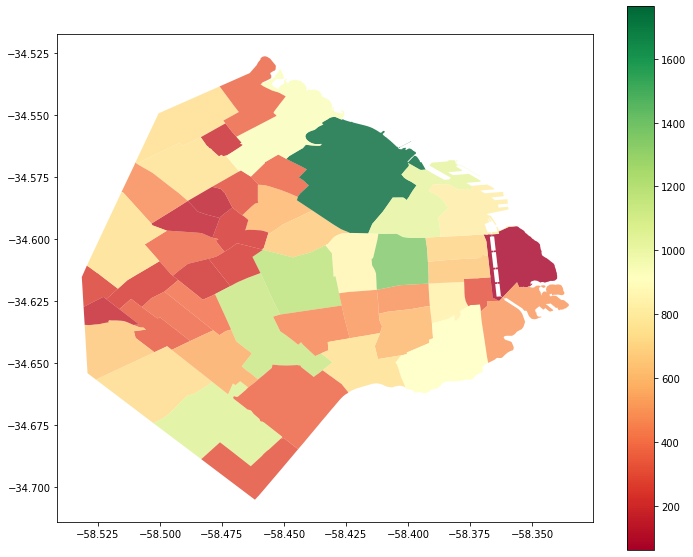

In [ ]:
# Grafico un mapa de la Capital teniendo en cuenta los valores de acceso, donde verde es el barrio con mayor acceso y rojo el menor
barrios_gdf.plot(column='acceso', cmap='RdYlGn',legend=True,figsize=(12,10),alpha=0.8)

In [13]:
import folium 
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap

In [ ]:
bicis.head()

,WKT,id,numero,nombre,ubicacion,tipo,horario,anclajes_t,lat,long,barrio
0,POINT (-58.3747109506359 -34.5924239181221),2,2,002 - Retiro I,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.592424,-58.374711,RETIRO
1,POINT (-58.368256111128 -34.611033074021),3,3,003 - ADUANA,Moreno & Av Paseo Colon,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.611033,-58.368256,MONSERRAT
2,POINT (-58.3687766674259 -34.6018228613782),4,4,004 - Plaza Roma,Lavalle & Bouchard,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.601823,-58.368777,SAN NICOLAS
3,POINT (-58.420951914897 -34.5805498216604),5,5,005 - Plaza Italia,Av. Sarmiento 2601,AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,42,-34.580550,-58.420952,PALERMO
4,POINT (-58.3697538990917 -34.6285274659984),6,6,006 - Parque Lezama,"Avenida Martin Garcia, 295",AUTOMÁTICA,Estación automática: disponibilidad las 24 horas,20,-34.628527,-58.369754,SAN TELMO


In [ ]:
trenes_capital.head()

In [ ]:
bicis["tipo"] = 'bicicleta'
subte["tipo"]= 'subte'
colectivos_capital["tipo"] = 'colectivo'
trenes_capital["tipo"] = 'tren'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
todos = pd.concat([subte.loc[:,["lat","long","tipo"]], bicis.loc[:,["lat","long","tipo"]], colectivos_capital.loc[:,["lat","long","tipo"]], trenes_capital.loc[:,["lat","long","tipo"]]],axis=0)

In [ ]:
todos=todos.reset_index(drop='index')

In [ ]:
todos.loc[todos.tipo.isin(medios_transporte)]

In [ ]:
todos.to_csv('ubicacion_movilidad.csv')

In [ ]:
m=folium.Map(location=[-34.603722,-58.381592],zoom_start=10,min_zoom=11)
Subtes=FeatureGroup(name='Subtes',show=False) #FeatureGroup para personalizar las capas (Layers)
Bicis=FeatureGroup(name='Bicis')
Colectivos=FeatureGroup(name='Colectivos')
Trenes=FeatureGroup(name='Trenes')
#Heatmap=FeatureGroup(name='Heatmap')

for i in range(0,subte.shape[0]):
  lat=subte.loc[i,'lat']
  lon=subte.loc[i,'long']
  folium.CircleMarker([lat,lon],radius=2,color='Yellow').add_to(Subtes) #Cada  capa necesita un ciclo para marcar todos los puntos
for x in range(0,bicis.shape[0]):
  lat_=bicis.loc[x,'lat']
  lon_=bicis.loc[x,'long']
  folium.CircleMarker([lat_,lon_],radius=2,color='Orange').add_to(Bicis)
for x in range(0,colectivos_capital.shape[0]):
  lat_=colectivos_capital.loc[x,'lat']
  lon_=colectivos_capital.loc[x,'long']
  folium.CircleMarker([lat_,lon_],radius=2,color='red').add_to(Colectivos)
for x in range(0,trenes_capital.shape[0]):
  lat_=trenes_capital.loc[x,'lat']
  lon_=trenes_capital.loc[x,'long']
  folium.CircleMarker([lat_,lon_],radius=2,color='blue').add_to(Trenes)

#HeatMap(data=todos[['lat', 'long']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=10, max_zoom=13).add_to(Heatmap)
#plugins.HeatMap(data, radius = 10, min_opacity = 0.1, max_val = 50,gradient=gradiente).add_to(m)
Colectivos.add_to(m)
Subtes.add_to(m)
Bicis.add_to(m) #Se agrega cada capa al mapa
Trenes.add_to(m)
LayerControl().add_to(m)
#Heatmap.add_to(m)

m



In [9]:
todos=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATOS EANT/PROYECTO/ubicacion_movilidad.csv',usecols=['lat','long','tipo'])

In [15]:
colores_transporte={'subte':'red', 'bicicleta':'yellow', 'colectivo':'green', 'tren':'blue'}

In [16]:
todos.describe()

,lat,long
count,8680.000000,8680.000000
mean,-34.613134,-58.441113
std,0.031735,0.045488
min,-34.704515,-58.531412
25%,-34.635330,-58.477578
50%,-34.613911,-58.441526
75%,-34.590473,-58.402823
max,-34.535837,-58.343382


In [ ]:
#mapa de prueba

m=folium.Map(location=[-34.613134	,-58.441113],zoom_start=10,min_zoom=11)
Subtes=FeatureGroup(name='Subtes')
#Heatmap=FeatureGroup(name='Heatmap')

for i in range(0,todos.shape[0]):
  lat=todos.loc[i,'lat']
  lon=todos.loc[i,'long']
  color_tipo=colores_transporte[str(todos.loc[i,'tipo'])]
  folium.CircleMarker([lat,lon],radius=2,color=color_tipo).add_to(Subtes) #Cada  capa necesita un ciclo para marcar todos los puntos

#HeatMap(data=todos[['lat', 'long']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=10, max_zoom=13).add_to(Heatmap)
#plugins.HeatMap(data, radius = 10, min_opacity = 0.1, max_val = 50,gradient=gradiente).add_to(m)

Subtes.add_to(m)

#Heatmap.add_to(m)

m.save('mapa_de_barrios.html')


In [ ]:
#heat map revisar
m=folium.Map(location=[-34.603722,-58.381592],zoom_start=11,min_zoom=12)
#min zoom l
Heatmap=FeatureGroup(name='Heatmap')


HeatMap(data=todos[['lat', 'long']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=5, max_val=50,).add_to(Heatmap)
#plugins.HeatMap(data, radius = 10, min_opacity = 0.1, max_val = 50,gradient=gradiente).add_to(m)
Heatmap.add_to(m)
LayerControl().add_to(m)


m

In [20]:
todos_dash=todos

In [21]:
todos.tipo.unique()

array(['subte', 'bicicleta', 'colectivo', 'tren'], dtype=object)

In [22]:
todos_dash=todos
#mapa 
m=folium.Map(location=[-34.613134	,-58.441113],zoom_start=10,min_zoom=11)
Subtes=FeatureGroup(name='Subtes')


for i in range(0,todos.shape[0]):
  lat=todos.loc[i,'lat']
  lon=todos.loc[i,'long']
  color_tipo=colores_transporte[str(todos.loc[i,'tipo'])]
  folium.CircleMarker([lat,lon],radius=2,color=color_tipo).add_to(Subtes) #Cada  capa necesita un ciclo para marcar todos los puntos

Subtes.add_to(m)


m.save('mapa_de_barrios.html')

In [23]:

#App
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(external_stylesheets=external_stylesheets)


#Layout
app.layout = html.Div([
    html.H1('Movilidad CABA',className='twelve columns'),
    dcc.Dropdown(id='drop_medios_transpote',options=[{'label':'Subtes','value':'subte'},
                                               {'label':'Colectivos','value':'colectivo'},
                                               {'label':'Trenes','value':'tren'},
                                               {'label':'Bicicletas','value':'bicicleta'}],
                 multi=True,value=['subte','colectivo','tren','bicicleta']),
    html.Br(),
    html.Iframe(id='mapa',srcDoc= open('mapa_de_barrios.html','r').read(),width='100%',height='500')
  
])

@app.callback(
    Output(component_id='mapa', component_property='srcDoc'),
    [Input(component_id='drop_medios_transpote', component_property='value')]
)

def update_mapa(transporte_seleccionado):
  todos_dash=todos.loc[todos.tipo.isin(transporte_seleccionado)]
  m=folium.Map(location=[-34.613134	,-58.441113],zoom_start=10,min_zoom=11)
  Subtes=FeatureGroup(name='Subtes')

  for i in range(0,todos_dash.shape[0]):
    lat=todos_dash.loc[i,'lat']
    lon=todos_dash.loc[i,'long']
    color_tipo=colores_transporte[str(todos_dash.loc[i,'tipo'])]
    folium.CircleMarker([lat,lon],radius=2,color=color_tipo).add_to(Subtes) #Cada  capa necesita un ciclo para marcar todos los puntos

  Subtes.add_to(m)
  m.save('mapa_de_barrios.html')

  return open('mapa_de_barrios.html','r').read()


#Ejecutar
if __name__ == '__main__':
    app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
def update_mapa(transporte_seleccionado):
  todos_dash=todos.loc[todos.tipo.isin(transporte_seleccionado)]
  m=folium.Map(location=[-34.613134	,-58.441113],zoom_start=10,min_zoom=11)
  Subtes=FeatureGroup(name='Subtes')

  for i in range(0,todos_dash.shape[0]):
    lat=todos_dash.loc[i,'lat']
    lon=todos_dash.loc[i,'long']
    color_tipo=colores_transporte[str(todos_dash.loc[i,'tipo'])]
    folium.CircleMarker([lat,lon],radius=2,color=color_tipo).add_to(Subtes) #Cada  capa necesita un ciclo para marcar todos los puntos

  Subtes.add_to(m)


  return m